# Goals

* Create tiledb-soma database for the scRecounter `prod3` dataset

# Vars

In [36]:
work_dir = '/processed_datasets/scRecount/scRecounter'

# Init

In [37]:
import os
from glob import glob
import pandas as pd
import tiledbsoma
import tiledbsoma.io
import numpy as np
import plotnine as pn

In [38]:
pn.theme_set(pn.theme_bw())

In [39]:
db_uri = os.path.join(work_dir, 'tiledb-soma_prod3')
db_uri

'/processed_datasets/scRecount/scRecounter/tiledb-soma_prod3'

# Create

> Via tmux jobs to prevent disconnection

## GeneFull_Ex50pAS

```bash
./scripts/tiledb-loader.py \
  --threads 8 --skip-no-metadata --feature-type GeneFull_Ex50pAS --max-datasets 100 \
  --db-uri /processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull_Ex50pAS \
  /processed_datasets/scRecount/scRecounter/prod3 \
  > tiledb-loader_GeneFull_Ex50pAS.log 2>&1
```


## GeneFull

First 100 datasets:

```bash
./scripts/tiledb-loader.py \
  --threads 8 --skip-no-metadata --feature-type GeneFull --max-datasets 100 \
  --db-uri /processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull \
  /processed_datasets/scRecount/scRecounter/prod3
```


# Summary

## GeneFull_Ex50pAS

In [40]:
db_uri = "/processed_datasets/scRecount/scRecounter/tiledb-soma_prod3_GeneFull_Ex50pAS"

In [41]:
# get obs metadata overview
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

soma_joinid: int64 not null
obs_id: large_string
gene_count: int64
umi_count: float
barcode: large_string
SRX_accession: large_string
lib_prep: large_string
tech_10x: large_string
organism: large_string
tissue: large_string
disease: large_string
purturbation: large_string
cell_line: large_string
czi_collection_id: large_string
czi_collection_name: large_string


### Obs count

In [42]:
# total observations
with tiledbsoma.open(db_uri) as exp:
    print(
        exp.obs.read(column_names=["obs_id"])
        .concat()
        .group_by([])
        .aggregate([
            ([], 'count_all'),
        ])
        .to_pandas()
    )

   count_all
0     758611


In [58]:
# obs per SRX
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(['SRX_accession'])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.head()

(124, 2)


,SRX_accession,count_all
0,SRX26111881,36887
1,SRX23386174,25202
2,SRX17429793,24267
3,SRX12173116,18496
4,SRX24651627,18041


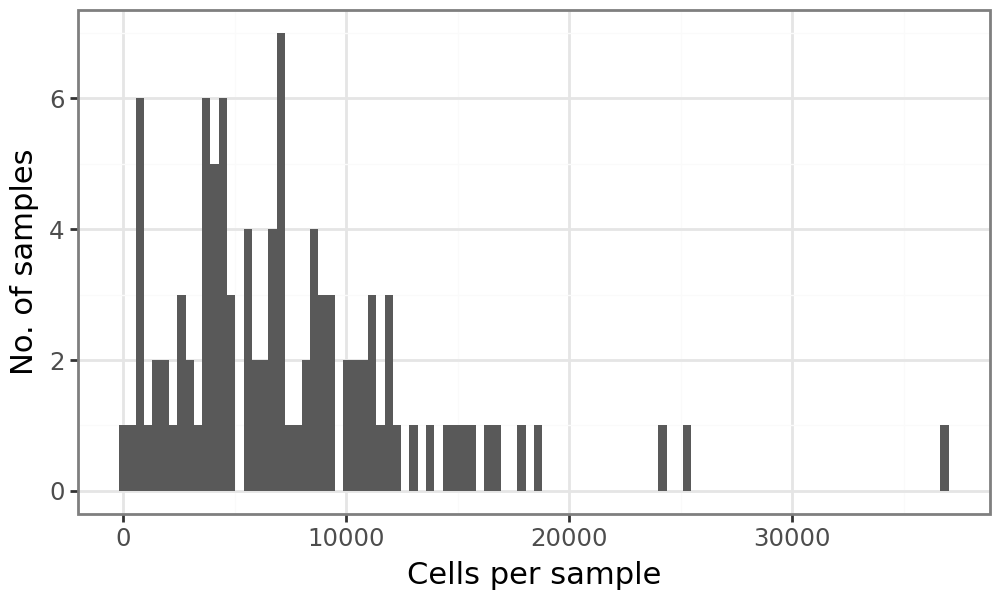

In [46]:
# plot cells per SRX
p = (
    pn.ggplot(df, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cells per sample", y="No. of samples") +
    pn.theme(figure_size=(5,3))
    )
p

In [47]:
# obs per SRX
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read()
        .concat()
        .group_by(["tech_10x"])
        .aggregate([
            ([], 'count_all'),
        ])
        .sort_by([("count_all", "descending")])
        .to_pandas()
    )
print(df.shape)
df.tail()

(7, 2)


,tech_10x,count_all
2,multiome,18872
3,not_applicable,18041
4,other,12640
5,feature_barcoding,10614
6,vdj,6302


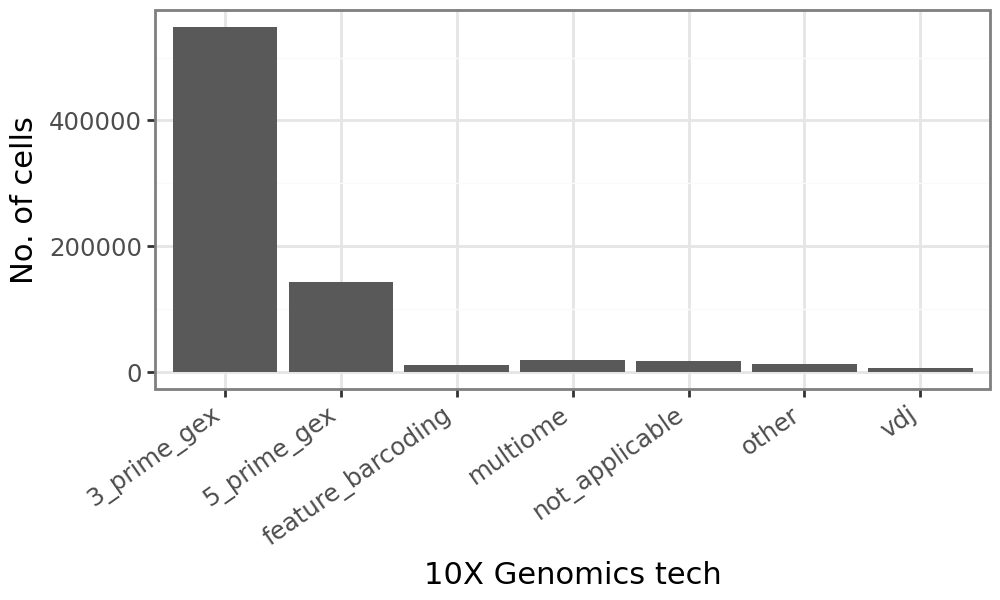

In [48]:
# plot cells per SRX and tech
p = (
    pn.ggplot(df, pn.aes(x="tech_10x", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="10X Genomics tech", y="No. of cells") +
    pn.theme(
        figure_size=(5,3),
        axis_text_x=pn.element_text(rotation=35, hjust=1)
    ))
p

### Gene/UMI counts

In [49]:
# gene and umi counts
with tiledbsoma.Experiment.open(db_uri) as exp:
    df = (
        exp.obs.read(column_names=["SRX_accession", "gene_count", "umi_count"])
        .concat()
        .sort_by([("gene_count", "descending")])
        .to_pandas()
    )
df

,SRX_accession,gene_count,umi_count
0,SRX25363536,16687,346175.0
1,SRX18899936,14987,251264.0
2,SRX18899936,14965,212983.0
3,SRX18899936,14753,190172.0
4,SRX18899936,14548,181595.0
...,...,...,...
758606,SRX26111881,1,4.0
758607,SRX26111881,1,5.0
758608,SRX26111881,1,6.0
758609,SRX26111881,1,4.0


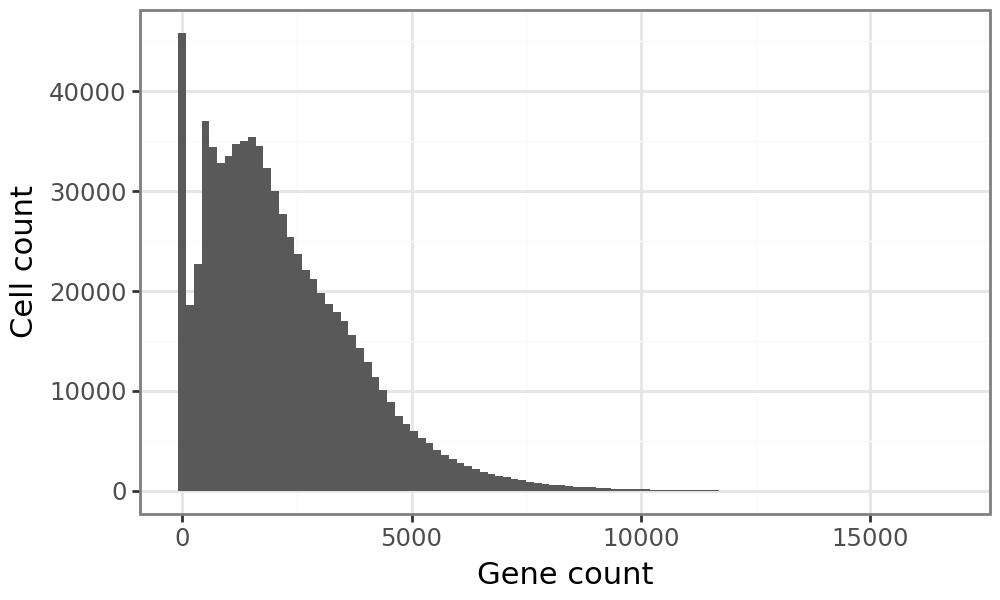

In [50]:
# plot genes per cell
p = (
    pn.ggplot(df, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Gene count", y="Cell count") +
    pn.theme(figure_size=(5,3))
    )
p

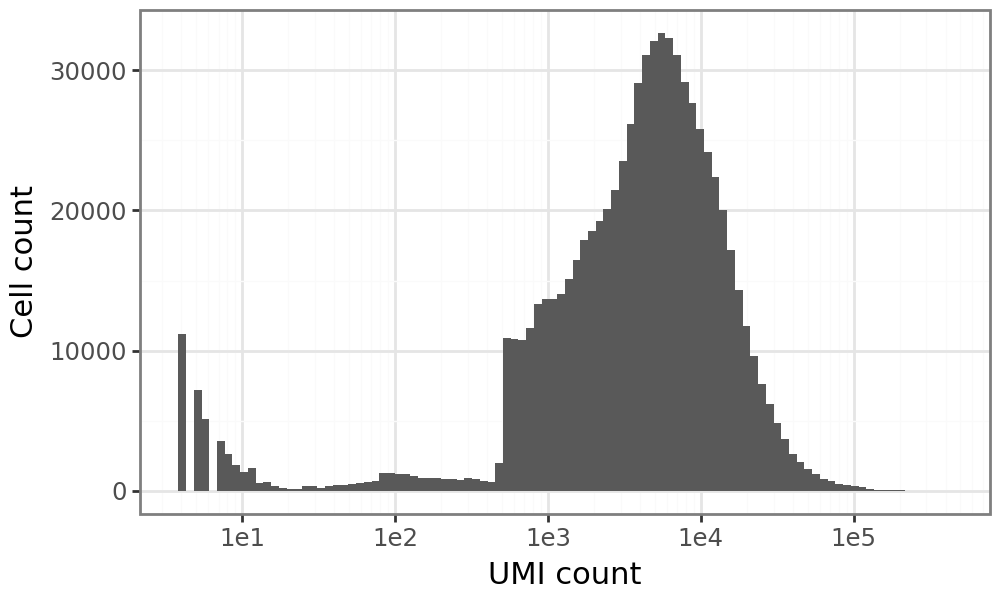

In [51]:
# plot UMIs per cell
p = (
    pn.ggplot(df, pn.aes(x="umi_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="UMI count", y="Cell count") +
    pn.theme(figure_size=(5,3))
    )
p

# Sandbox

In [52]:
# slice by metadata and return as anndata
obs_query = tiledbsoma.AxisQuery(value_filter='SRX_accession in ["SRX24651627"]')

with tiledbsoma.Experiment.open(db_uri) as exp:
    adata = exp.axis_query("RNA", obs_query=obs_query).to_anndata(X_name="data")
adata

AnnData object with n_obs × n_vars = 18041 × 68886
    obs: 'soma_joinid', 'obs_id', 'gene_count', 'umi_count', 'barcode', 'SRX_accession', 'lib_prep', 'tech_10x', 'organism', 'tissue', 'disease', 'purturbation', 'cell_line', 'czi_collection_id', 'czi_collection_name'
    var: 'soma_joinid', 'var_id', 'gene_symbols', 'feature_types'

In [56]:
with tiledbsoma.Experiment.open(db_uri) as exp:
    print(
        exp.axis_query("RNA", obs_query=obs_query)
        .obs()
        .concat()
        .to_pandas()
    )

       soma_joinid                        obs_id  gene_count  umi_count  \
0           441222  AAACCCAAGTATGTAG_SRX24651627        1727     2848.0   
1           441223  AAACCCACACATGTTG_SRX24651627        5073    17065.0   
2           441224  AAACCCACAGCGGTCT_SRX24651627        3216     7410.0   
3           441225  AAACCCAGTACTTGTG_SRX24651627        4358    14341.0   
4           441226  AAACCCAGTAGACTGG_SRX24651627        2850     6482.0   
...            ...                           ...         ...        ...   
18036       459258  TTTGTTGTCGGCATAT_SRX24651627        2689     6617.0   
18037       459259  TTTGTTGTCGGTTGTA_SRX24651627        2628     5367.0   
18038       459260  TTTGTTGTCTCTATGT_SRX24651627        4538    14614.0   
18039       459261  TTTGTTGTCTGTGCAA_SRX24651627        3512     8211.0   
18040       459262  TTTGTTGTCTTAGTTC_SRX24651627        1250     1992.0   

                barcode SRX_accession      lib_prep        tech_10x organism  \
0      AAACCCAAGTAT

In [23]:
import scanpy as sc

In [58]:
p = "/processed_datasets/scRecount/scRecounter/prod3/SCRECOUNTER_2025-01-16_14-55-07/STAR/SRX23665550/GeneFull/filtered/"
adata = sc.read_10x_mtx(p)
adata

AnnData object with n_obs × n_vars = 14844 × 32285
    var: 'gene_ids', 'feature_types'

In [60]:
# get obs_id
adata.obs.index

Index(['AAACCCAAGAATTGTG', 'AAACCCAAGCCTTTCC', 'AAACCCAAGCGTTCCG',
       'AAACCCAAGGTATAGT', 'AAACCCAAGTTTCGGT', 'AAACCCACAAAGCACG',
       'AAACCCACAAATACAG', 'AAACCCACACATATGC', 'AAACCCACACCCAAGC',
       'AAACCCACACCTATCC',
       ...
       'TTTGGTTTCTATCGTT', 'TTTGTTGAGCCTGGAA', 'TTTGTTGAGGAGGGTG',
       'TTTGTTGAGGGCTGAT', 'TTTGTTGAGTATGAAC', 'TTTGTTGCAACCCTCT',
       'TTTGTTGCACATAGCT', 'TTTGTTGCACGTTCGG', 'TTTGTTGCACTCCCTA',
       'TTTGTTGGTCTACATG'],
      dtype='object', length=14844)

In [28]:
#(adata.X > 0).sum(axis=1).A1
adata.X.sum(axis=1).A1

array([ 8611.,  2874.,  4688., ..., 14166.,  6238.,  5111.], dtype=float32)

In [31]:
(adata.X > 0).shape

(14844, 32285)